# XGBoost from scratch


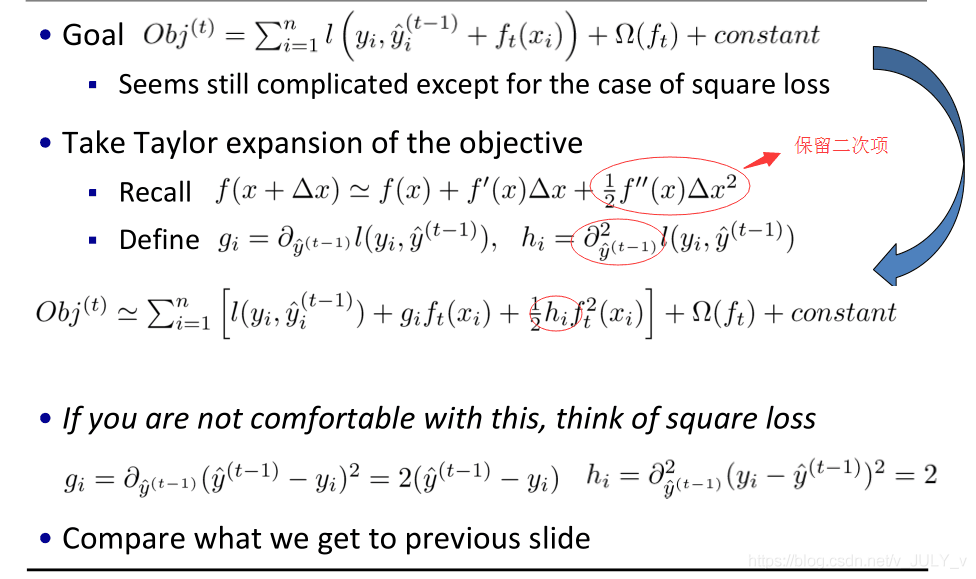

## The  XGBoost Model Class

We begin with the user-facing API for our model, a class called `XGBoostModel` which will implement gradient boosting and prediction.  To be more consistent with the XGBoost library, we'll pass hyperparameters to our model in a parameter dictionary, so our init method is going to pull relevant parameters out of the dictionary and set them as object attributes. Note the use of python's `defaultdict` so we don't have to worry about handling key errors if we try to access a parameter that the user didn't set in the dictionary.


In [1]:
import math
import numpy as np 
import pandas as pd
from collections import defaultdict

In [2]:
class XGBoostModel():
    '''XGBoost from Scratch
    '''
    
    def __init__(self, params, random_seed=None):
        self.params = defaultdict(lambda: None, params)
        self.subsample = self.params['subsample'] \
            if self.params['subsample'] else 1.0
        self.learning_rate = self.params['learning_rate'] \
            if self.params['learning_rate'] else 0.3
        self.base_prediction = self.params['base_score'] \
            if self.params['base_score'] else 0.5
        self.max_depth = self.params['max_depth'] \
            if self.params['max_depth'] else 5
        self.rng = np.random.default_rng(seed=random_seed)

The fit method, based on our classic GBM,  takes a feature dataframe, a target vector, the objective function, and the number of boosting rounds as arguments. The user-supplied objective function should be an object with loss, gradient, and hessian methods, each of which takes a target vector and a prediction vector as input; the loss method should return a scalar loss score, the gradient method should return a vector of gradients, and the  hessian method should return a vector of hessians. 

- step1:  In contrast to boosting in the classic GBM, instead of computing residuals between the current predictions and the target, we compute gradients and hessians of the loss function with respect to the current predictions  
        记一阶导为gradients: $ g_i=l^{\prime}\left(y_i, \widehat{y}_i^{(t-1)}\right) $
        二阶导为hessians: $h_i=l^{\prime \prime}\left(y_i, \widehat{y}_i^{(t-1)}\right)$.  
- step2: and instead of predicting residuals with a decision tree, we fit a special XGBoost tree booster (which we'll implement in a moment) using the gradients and hessians.

- step3: The rest of the fit method is the same as the classic GBM, and the predict method is identical too.

I've also added row subsampling by drawing a random subset of instance indices and passing them to the tree booster during each boosting round. 

In [35]:
def fit(self, X, y, objective, num_boost_round, verbose=False):
    current_predictions = self.base_prediction * np.ones(shape=y.shape)
    self.boosters = []
    for i in range(num_boost_round):
        ## compute gradients and hessians
        gradients = objective.gradient(y, current_predictions)
        hessians = objective.hessian(y, current_predictions)
        ## subsampling by drawing a random subset of instance indices and passing them to the tree booster during each boosting round
        sample_idxs = None if self.subsample == 1.0 \
            else self.rng.choice(len(y), 
                                 size=math.floor(self.subsample*len(y)), 
                                 replace=False)
        #set up the boost tree
        booster = TreeBooster(X, gradients, hessians, 
                              self.params, self.max_depth, sample_idxs)
        current_predictions += self.learning_rate * booster.predict(X)
        self.boosters.append(booster)
        if verbose: 
            print(f'[{i}] train loss = {objective.loss(y, current_predictions)}')
            
def predict(self, X):
    return (self.base_prediction + self.learning_rate 
            * np.sum([booster.predict(X) for booster in self.boosters], axis=0))

XGBoostModel.fit = fit
XGBoostModel.predict = predict            

All we have to do now is implement the tree booster.

## The XGBoost Tree Booster

The XGBoost tree booster is a modified version of the decision tree that we built in the decision tree from scratch post. Like the decision tree, we recursively build a binary tree structure by finding the best split rule for each node in the tree. 

- The main difference is the criterion for evaluating splits and the way that we define a leaf's predicted value. Instead of being functions of the target values of the instances in each node, the criterion and predicted values are functions of the instance gradients and hessians. Thus we need only make a couple of modifications to our previous decision tree implementation to create the XGBoost tree booster.

### Initialization and Inserting Child Nodes
Most of the init method is just parsing the parameter dictionary to assign parameters as object attributes. 

- The one notable difference from our decision tree is in the way we define the node's predicted value. We define `self.value` according to equation 5 of the XGBoost paper, a simple function of the gradient and hessian values of the instances in the current node. Of course the init also goes on to build the tree via the maybe insert child nodes method. This method is nearly identical to the one we implemented for our decision tree. So far so good. 

Note: XGBoost目标函数的各个叶子结点的目标式子是相互独立的。即每个叶子结点的式子都达到最值点，整个目标函数也达到最值点。则每个叶子结点的权重 $w_j^*$ 及此时达到最优的 $O b j$ 目标值 :
$$
w_j^*=-\frac{G_j}{H_j+\lambda} \quad O b j=-\frac{1}{2} \sum_{j=1}^T \frac{G_j{ }^2}{H_j+\lambda}+\gamma T
$$

In [36]:
class TreeBooster():
    #init get the input include gradient and hessian value of all data
    def __init__(self, X, g, h, params, max_depth, idxs=None):
        self.params = params
        self.max_depth = max_depth
        assert self.max_depth >= 0, 'max_depth must be nonnegative'
        self.min_child_weight = params['min_child_weight'] \
            if params['min_child_weight'] else 1.0
        self.reg_lambda = params['reg_lambda'] if params['reg_lambda'] else 1.0
        self.gamma = params['gamma'] if params['gamma'] else 0.0
        self.colsample_bynode = params['colsample_bynode'] \
            if params['colsample_bynode'] else 1.0
        #if dataframe then covnert to data array
        if isinstance(g, pd.Series): g = g.values
        if isinstance(h, pd.Series): h = h.values
        if idxs is None: idxs = np.arange(len(g))
        self.X, self.g, self.h, self.idxs = X, g, h, idxs
        self.n, self.c = len(idxs), X.shape[1]
        
        #set the top node w value /predict value
        self.value = -g[idxs].sum() / (h[idxs].sum() + self.reg_lambda) # Eq (5)
        
        #init stat , if later have no change(no split so far) , it means it is leaf node
        self.best_score_so_far = 0.
        if self.max_depth > 0:
            self._maybe_insert_child_nodes()

    #try to build one node for the tree
    def _maybe_insert_child_nodes(self):
        for i in range(self.c): self._find_better_split(i)
        if self.is_leaf: return
        x = self.X.values[self.idxs,self.split_feature_idx]
        left_idx = np.nonzero(x <= self.threshold)[0]
        right_idx = np.nonzero(x > self.threshold)[0]
        self.left = TreeBooster(self.X, self.g, self.h, self.params, 
                                self.max_depth - 1, self.idxs[left_idx])
        self.right = TreeBooster(self.X, self.g, self.h, self.params, 
                                 self.max_depth - 1, self.idxs[right_idx])

    @property
    def is_leaf(self): return self.best_score_so_far == 0.

    def _find_better_split(self, feature_idx):
        pass

### Split Finding

Split finding follows the exact same pattern that we used in the decision tree, except we keep track of gradient and hessian stats instead of target value stats, and of course we use the XGBoost gain criterion (equation 7 from the paper) for evaluating splits. 

$$O b j=-\frac{1}{2} \sum_{j=1}^T \frac{G_j^2}{H_j+\lambda}+\gamma T$$

$$ { Gain }=\frac{1}{2}\left[\frac{G_L^2}{H_L+\lambda}+\frac{G_R^2}{H_R+\lambda}-\frac{\left(G_L+G_R\right)^2}{H_L+H_R+\lambda}\right]-\gamma$$

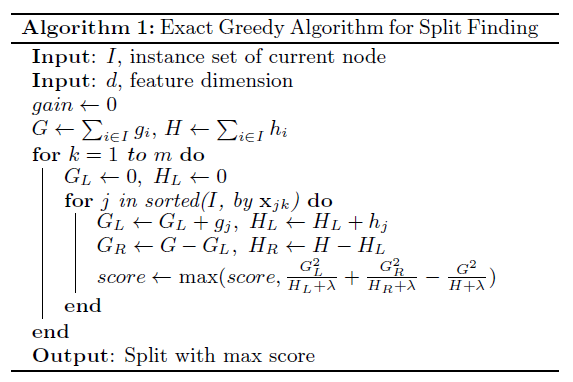

In [37]:
def _find_better_split(self, feature_idx):
    x = self.X.values[self.idxs, feature_idx]
    g, h = self.g[self.idxs], self.h[self.idxs]
    #sort the data with x feature
    sort_idx = np.argsort(x)
    sort_g, sort_h, sort_x = g[sort_idx], h[sort_idx], x[sort_idx]
    #init the GL, GR, HL, HR
    sum_g, sum_h = g.sum(), h.sum()
    sum_g_right, sum_h_right = sum_g, sum_h
    sum_g_left, sum_h_left = 0., 0.

    for i in range(0, self.n - 1):
        #cacluate the  GL, GR, HL, HR under the split point is i
        g_i, h_i, x_i, x_i_next = sort_g[i], sort_h[i], sort_x[i], sort_x[i + 1]
        sum_g_left += g_i; sum_g_right -= g_i
        sum_h_left += h_i; sum_h_right -= h_i
        
        #set up the break condition from iteration
        #what the considtion that x_i == x_i_next??
        if sum_h_left < self.min_child_weight or x_i == x_i_next:continue
        if sum_h_right < self.min_child_weight: break
        
        # calcuate the gain 
        gain = 0.5 * ((sum_g_left**2 / (sum_h_left + self.reg_lambda))
                        + (sum_g_right**2 / (sum_h_right + self.reg_lambda))
                        - (sum_g**2 / (sum_h + self.reg_lambda))
                        ) - self.gamma/2 # Eq(7) in the xgboost paper
        
        #record this split if the gain is better
        if gain > self.best_score_so_far: 
            self.split_feature_idx = feature_idx
            self.best_score_so_far = gain
            self.threshold = (x_i + x_i_next) / 2
            
TreeBooster._find_better_split = _find_better_split

### Prediction

Prediction works exactly the same as in our decision tree, and the methods are nearly identical.

In [38]:
def predict(self, X):
    return np.array([self._predict_row(row) for i, row in X.iterrows()])

def _predict_row(self, row):
    if self.is_leaf: 
        return self.value
    child = self.left if row[self.split_feature_idx] <= self.threshold \
        else self.right
    return child._predict_row(row)

TreeBooster.predict = predict 
TreeBooster._predict_row = _predict_row 

## The Complete XGBoost From Scratch Implementation

Here's the entire implementation which produces a usable `XGBoostModel` class with fit and predict methods.

In [39]:
class XGBoostModel():
    '''XGBoost from Scratch
    '''
    
    def __init__(self, params, random_seed=None):
        self.params = defaultdict(lambda: None, params)
        self.subsample = self.params['subsample'] \
            if self.params['subsample'] else 1.0
        self.learning_rate = self.params['learning_rate'] \
            if self.params['learning_rate'] else 0.3
        self.base_prediction = self.params['base_score'] \
            if self.params['base_score'] else 0.5
        self.max_depth = self.params['max_depth'] \
            if self.params['max_depth'] else 5
        self.rng = np.random.default_rng(seed=random_seed)
                
    def fit(self, X, y, objective, num_boost_round, verbose=False):
        current_predictions = self.base_prediction * np.ones(shape=y.shape)
        self.boosters = []
        for i in range(num_boost_round):
            gradients = objective.gradient(y, current_predictions)
            hessians = objective.hessian(y, current_predictions)
            sample_idxs = None if self.subsample == 1.0 \
                else self.rng.choice(len(y), 
                                     size=math.floor(self.subsample*len(y)), 
                                     replace=False)
            booster = TreeBooster(X, gradients, hessians, 
                                  self.params, self.max_depth, sample_idxs)
            current_predictions += self.learning_rate * booster.predict(X)
            self.boosters.append(booster)
            if verbose: 
                print(f'[{i}] train loss = {objective.loss(y, current_predictions)}')
            
    def predict(self, X):
        return (self.base_prediction + self.learning_rate 
                * np.sum([booster.predict(X) for booster in self.boosters], axis=0))

In [40]:
class TreeBooster():
 
    def __init__(self, X, g, h, params, max_depth, idxs=None):
        self.params = params
        self.max_depth = max_depth
        assert self.max_depth >= 0, 'max_depth must be nonnegative'
        self.min_child_weight = params['min_child_weight'] \
            if params['min_child_weight'] else 1.0
        self.reg_lambda = params['reg_lambda'] if params['reg_lambda'] else 1.0
        self.gamma = params['gamma'] if params['gamma'] else 0.0
        self.colsample_bynode = params['colsample_bynode'] \
            if params['colsample_bynode'] else 1.0
        if isinstance(g, pd.Series): g = g.values
        if isinstance(h, pd.Series): h = h.values
        if idxs is None: idxs = np.arange(len(g))
        self.X, self.g, self.h, self.idxs = X, g, h, idxs
        self.n, self.c = len(idxs), X.shape[1]
        self.value = -g[idxs].sum() / (h[idxs].sum() + self.reg_lambda) # Eq (5)
        self.best_score_so_far = 0.
        if self.max_depth > 0:
            self._maybe_insert_child_nodes()

    def _maybe_insert_child_nodes(self):
        for i in range(self.c): self._find_better_split(i)
        if self.is_leaf: return
        x = self.X.values[self.idxs,self.split_feature_idx]
        left_idx = np.nonzero(x <= self.threshold)[0]
        right_idx = np.nonzero(x > self.threshold)[0]
        self.left = TreeBooster(self.X, self.g, self.h, self.params, 
                                self.max_depth - 1, self.idxs[left_idx])
        self.right = TreeBooster(self.X, self.g, self.h, self.params, 
                                 self.max_depth - 1, self.idxs[right_idx])

    @property
    def is_leaf(self): return self.best_score_so_far == 0.
    
    def _find_better_split(self, feature_idx):
        x = self.X.values[self.idxs, feature_idx]
        g, h = self.g[self.idxs], self.h[self.idxs]
        sort_idx = np.argsort(x)
        sort_g, sort_h, sort_x = g[sort_idx], h[sort_idx], x[sort_idx]
        sum_g, sum_h = g.sum(), h.sum()
        sum_g_right, sum_h_right = sum_g, sum_h
        sum_g_left, sum_h_left = 0., 0.

        for i in range(0, self.n - 1):
            g_i, h_i, x_i, x_i_next = sort_g[i], sort_h[i], sort_x[i], sort_x[i + 1]
            sum_g_left += g_i; sum_g_right -= g_i
            sum_h_left += h_i; sum_h_right -= h_i
            if sum_h_left < self.min_child_weight or x_i == x_i_next:continue
            if sum_h_right < self.min_child_weight: break

            gain = 0.5 * ((sum_g_left**2 / (sum_h_left + self.reg_lambda))
                            + (sum_g_right**2 / (sum_h_right + self.reg_lambda))
                            - (sum_g**2 / (sum_h + self.reg_lambda))
                            ) - self.gamma/2 # Eq(7) in the xgboost paper
            if gain > self.best_score_so_far: 
                self.split_feature_idx = feature_idx
                self.best_score_so_far = gain
                self.threshold = (x_i + x_i_next) / 2
                
    def predict(self, X):
        return np.array([self._predict_row(row) for i, row in X.iterrows()])

    def _predict_row(self, row):
        if self.is_leaf: 
            return self.value
        child = self.left if row[self.split_feature_idx] <= self.threshold \
            else self.right
        return child._predict_row(row)

## Testing

Let's take this baby for a spin and benchmark its performance against the actual XGBoost library. We use the scikit learn [California housing dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html) for benchmarking.

In [41]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
    
X, y = fetch_california_housing(as_frame=True, return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=43)

Let's start with a nice friendly squared error objective function for training. We should probably have a future post all about how to define custom objective functions in XGBoost, but for now, here's how I define squared error.  
   gradients: $g_i=l^{\prime}\left(y_i, \widehat{y}_i^{(t-1)}\right)$ ，hessians: $h_i=l^{\prime \prime}\left(y_i, \widehat{y}_i^{(t-1)}\right)$.  

In [42]:
class SquaredErrorObjective():
    def loss(self, y, pred): return np.mean((y - pred)**2)
    def gradient(self, y, pred): return pred - y
    def hessian(self, y, pred): return np.ones(len(y))

Here I use a more or less arbitrary set of hyperparameters for training.  Feel free to play around with tuning and trying other parameter combinations yourself. 

In [ ]:
import xgboost as xgb

params = {
    'learning_rate': 0.1,
    'max_depth': 5,
    'subsample': 0.8,
    'reg_lambda': 1.5,
    'gamma': 0.0,
    'min_child_weight': 25,
    'base_score': 0.0,
    'tree_method': 'exact',
}
num_boost_round = 50

# train the from-scratch XGBoost model
model_scratch = XGBoostModel(params, random_seed=42)
model_scratch.fit(X_train, y_train, SquaredErrorObjective(), num_boost_round)

# train the library XGBoost model
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
model_xgb = xgb.train(params, dtrain, num_boost_round)

In [ ]:
X_train.shape

In [ ]:
y_train.shape

Let's check the models' performance on the held out test data to benchmark our implementation.

In [ ]:
pred_scratch_train = model_scratch.predict(X_train)
pred_scratch = model_scratch.predict(X_test)
pred_xgb = model_xgb.predict(dtest)
print(f'scratch score: {SquaredErrorObjective().loss(y_test, pred_scratch)}')
print(f'xgboost score: {SquaredErrorObjective().loss(y_test, pred_xgb)}')

In [ ]:
def RSE(y, g): 
    return sum(np.square(y - g)) / sum(np.square(y - 1 / len(y)*sum(y)))

print('Training error: {:.4f}'.format(RSE(y_train, pred_scratch_train)))
print('Validation error: {:.4f}'.format(RSE(y_test, pred_scratch)))

Well, look at that! Our scratch-built SGBoost is looking pretty consistent with the library. Go us!

## Wrapping Up
I'd say this is a pretty good milestone for us here at Random Realizations. We've been hammering away at the various concepts around gradient boosting, leaving a trail of equations and scratch-built algos in our wake. Today we put all of that together to create a legit scratch build of XGBoost, something that would have been out of reach for me before we embarked on this journey together over a year ago. To anyone with the patience to read through this stuff, cheers to you! I hope you're learning and enjoying this as much as I am. 

## Reader Exercises
If you want to take this a step further and deepen your understanding and coding abilities, let me recommend some exercises for you. 

1. Implement column subsampling. XGBoost itself provides column subsampling by tree, by level, and by node. Try implementing by tree first, then try adding by level or by node as well. These should be pretty straightforward to do.
1. Implement sparsity aware split finding for missing feature values (Algorithm 2 in the [XGBoost paper](https://arxiv.org/abs/1603.02754)). This will be a little more involved, since you'll need to refactor and modify several parts of the tree booster class.
